In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
# Load and preprocess MNIST
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))
#Generate noisy versions
noise_factor_low = 0.1
noise_factor_high = 0.5
x_train_noisy_low = x_train + noise_factor_low * np.random.normal(loc=0.0, scale=1.0, size=x_train.
shape)
x_train_noisy_high = x_train + noise_factor_high * np.random.normal(loc=0.0, scale=1.0, size=x_train
.shape)
x_test_noisy_low = x_test + noise_factor_low * np.random.normal(loc=0.0, scale=1.0, size=x_test.
shape)
x_test_noisy_high = x_test + noise_factor_high * np.random.normal(loc=0.0, scale=1.0, size=x_test.
shape)
# Clip pixel values to [0, 1]
x_train_noisy_low = np.clip(x_train_noisy_low, 0., 1.)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


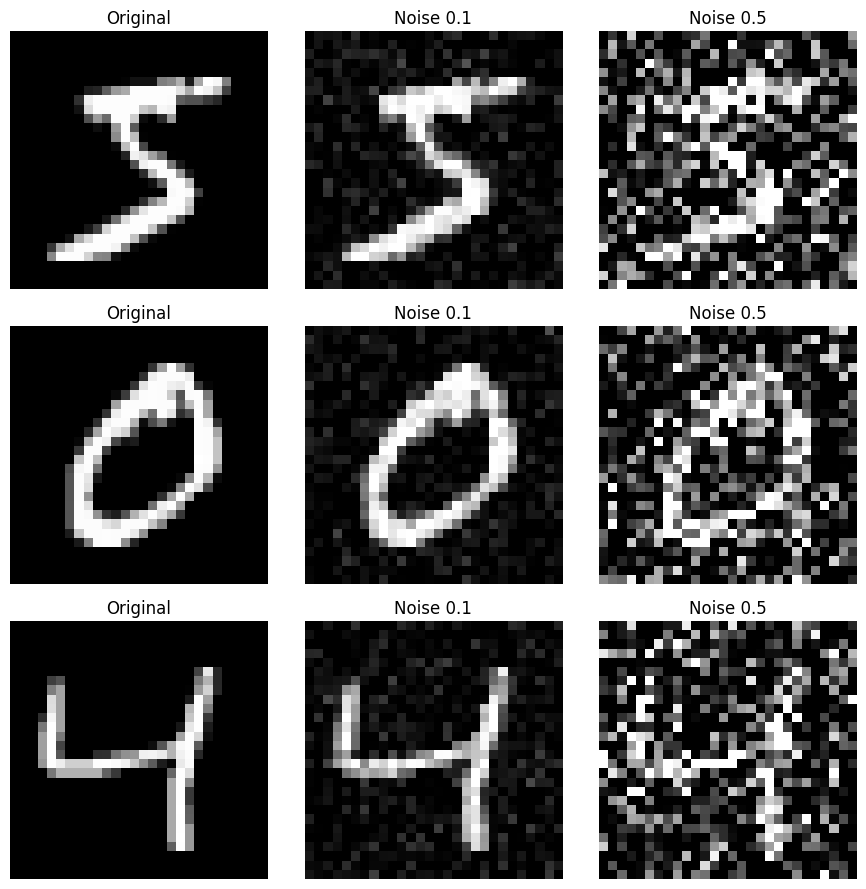

In [ ]:
x_test_noisy_low = np.clip(x_test_noisy_low, 0., 1.)
x_train_noisy_high = np.clip(x_train_noisy_high, 0., 1.)
x_test_noisy_high = np.clip(x_test_noisy_high, 0., 1.)
#Visualize in a 3 x 3 grid
n = 3 # number of images to show
plt.figure(figsize=(9, 9))
for i in range(n):
  # Original image
  ax = plt.subplot(n, 3, i * 3 + 1)
  plt.imshow(x_train[i].reshape(28, 28), cmap='gray')
  plt.title("Original")
  plt.axis('off')
  # Low noise image
  ax = plt.subplot(n, 3, i * 3 + 2)
  plt.imshow(x_train_noisy_low[i].reshape(28, 28), cmap='gray')
  plt.title("Noise 0.1")
  plt.axis('off')
  # High noise image
  ax = plt.subplot(n, 3, i * 3 + 3)
  plt.imshow(x_train_noisy_high[i].reshape(28, 28), cmap='gray')
  plt.title("Noise 0.5")
  plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
def build_encoder(input_shape=(28, 28, 1)):
    """
    Builds the encoder part of the convolutional autoencoder.

    Parameters:
    input_shape (tuple): Shape of the input image. Default is (28, 28, 1) for MNIST.

    Returns:
    input_img (Keras Input): Input layer of the model.
    encoded (Keras Tensor): Encoded representation after convolution and pooling.
    """
    input_img = Input(shape=input_shape, name="input")
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same', name="encoded")(x)
    return input_img, encoded

In [ ]:
def build_decoder(encoded_input):
    """
    Builds the decoder part of the convolutional autoencoder.

    Parameters:
    encoded_input (Keras Tensor): The output from the encoder.

    Returns:
    decoded (Keras Tensor): The reconstructed output after upsampling and convolution.
    """
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded_input)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name="decoded")(x)
    return decoded

In [ ]:
def build_autoencoder():
    """
    Constructs and compiles the full convolutional autoencoder by connecting encoder and decoder.

    Returns:
    autoencoder (Keras Model): Compiled autoencoder model.
    """
    input_img, encoded_output = build_encoder()
    decoded_output = build_decoder(encoded_output)
    autoencoder = Model(inputs=input_img, outputs=decoded_output, name="autoencoder")
    autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy')
    return autoencoder

In [ ]:
autoencoder = build_autoencoder()
autoencoder.summary()


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoded (MaxPooling2D)          │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoded (Conv2D)                │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.2427 - val_loss: 0.1121
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.1114 - val_loss: 0.1057
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1059 - val_loss: 0.1029
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1029 - val_loss: 0.1007
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.1008 - val_loss: 0.0988
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0992 - val_loss: 0.0979
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0986 - val_loss: 0.0971
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0975 - val_loss: 0.0966
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0970 - val_loss: 0.0961
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0963 - val_loss: 0.0954


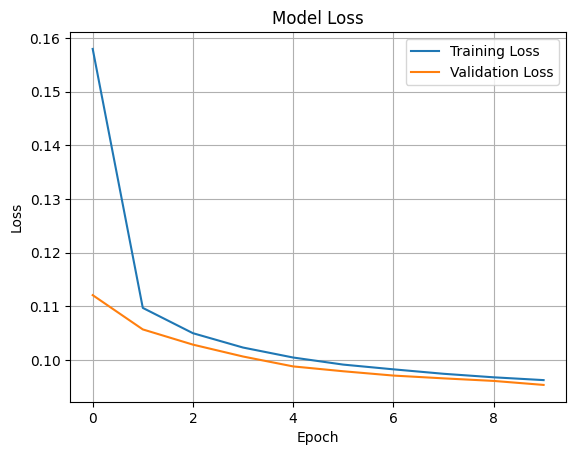

In [ ]:
import matplotlib.pyplot as plt

# Build the autoencoder
autoencoder = build_autoencoder()

# Train the model
history = autoencoder.fit(
    x_train_noisy_high, x_train,
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_noisy_high, x_test)
)

# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


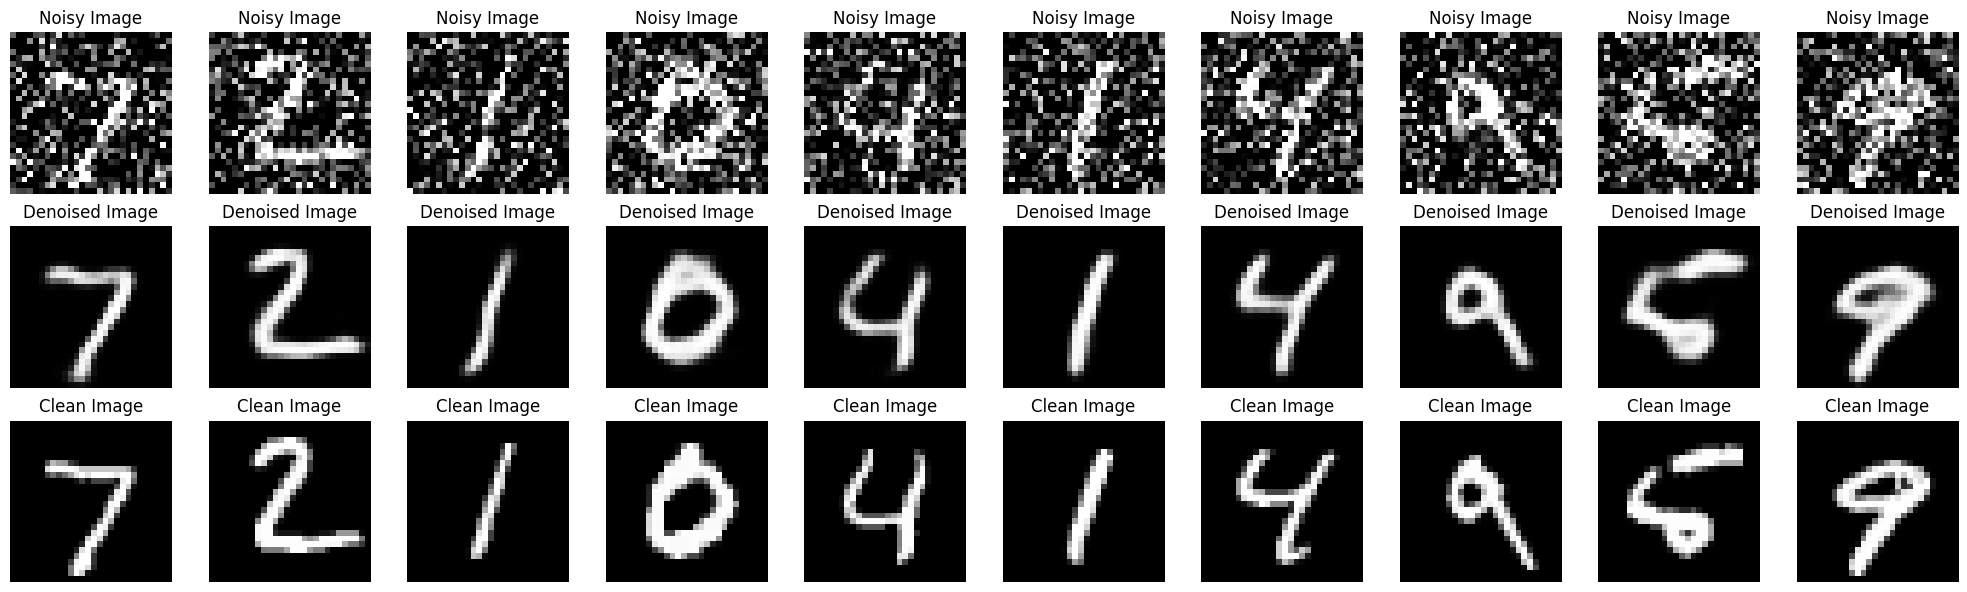

In [ ]:
import matplotlib.pyplot as plt

# Predict using high noise test images
denoised_images = autoencoder.predict(x_test_noisy_high)

# Plot noisy, denoised, and clean images
def plot_images(noisy_images, denoised_images, clean_images, n=10):
    plt.figure(figsize=(20, 6))
    for i in range(n):
        # Noisy image
        plt.subplot(3, n, i + 1)
        plt.imshow(noisy_images[i].reshape(28, 28), cmap='gray')
        plt.title("Noisy Image")
        plt.axis('off')

        # Denoised image
        plt.subplot(3, n, i + 1 + n)
        plt.imshow(denoised_images[i].reshape(28, 28), cmap='gray')
        plt.title("Denoised Image")
        plt.axis('off')

        # Clean original image
        plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(clean_images[i].reshape(28, 28), cmap='gray')
        plt.title("Clean Image")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Show the images
plot_images(x_test_noisy_high, denoised_images, x_test, n=10)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
import os

dataset_path = "/content/drive/MyDrive/week-4_(AI)/DevanagariHandwrittenDigitDataset.zip"
extract_path = "/content/DevanagariMNIST"
# Extract the zip file
with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Verify the extraction
os.listdir(extract_path)
# List all extracted folders/files
# List contents inside the DevanagariHandwrittenDigitDataset folder
print("Contents of DevanagariHandwrittenDigitDataset:", os.listdir("/content/DevanagariMNIST/DevanagariHandwrittenDigitDataset"))


Contents of DevanagariHandwrittenDigitDataset: ['.DS_Store', 'Train', 'Test']


In [ ]:
from PIL import Image
import numpy as np
import os
import glob
from sklearn.model_selection import train_test_split

# Load images into an array
image_dir = "/content/DevanagariMNIST/DevanagariHandwrittenDigitDataset/Train"

img_size = 32  # The Devnagari dataset typically uses 32x32

images = []
for folder in os.listdir(image_dir):
    folder_path = os.path.join(image_dir, folder)
    for img_file in glob.glob(os.path.join(folder_path, "*.png")):
        img = Image.open(img_file).convert('L').resize((img_size, img_size))
        img_array = np.array(img) / 255.0  # Normalize to [0,1]
        images.append(img_array)

images = np.array(images)
images = np.reshape(images, (-1, img_size, img_size, 1))  # Add channel dimension
print("Shape:", images.shape)


Shape: (17000, 32, 32, 1)


In [ ]:
# Split data
x_train, x_test = train_test_split(images, test_size=0.2, random_state=42)

# Add Gaussian noise
noise_factor = 0.4
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

# Clip values
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam

def build_autoencoder(input_shape=(32, 32, 1)):
    input_img = Input(shape=input_shape)

    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy')
    return autoencoder

autoencoder = build_autoencoder()
autoencoder.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_6 (UpSampling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 16, 16, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_7 (UpSampling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = autoencoder.fit(
    x_train_noisy, x_train,
    epochs=20,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_noisy, x_test)
)


Epoch 1/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.4096 - val_loss: 0.1688
Epoch 2/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1658 - val_loss: 0.1546
Epoch 3/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1543 - val_loss: 0.1533
Epoch 4/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1495 - val_loss: 0.1469
Epoch 5/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1469 - val_loss: 0.1448
Epoch 6/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1442 - val_loss: 0.1435
Epoch 7/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1435 - val_loss: 0.1418
Epoch 8/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1413 - val_loss: 0.1407
Epoch 9/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1403 - val_loss: 0.1404
Epoch 10/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1396 - val_loss: 0.1397
Epoch 11/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1392 - val_loss: 0.1385
Epoch 12/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/ste

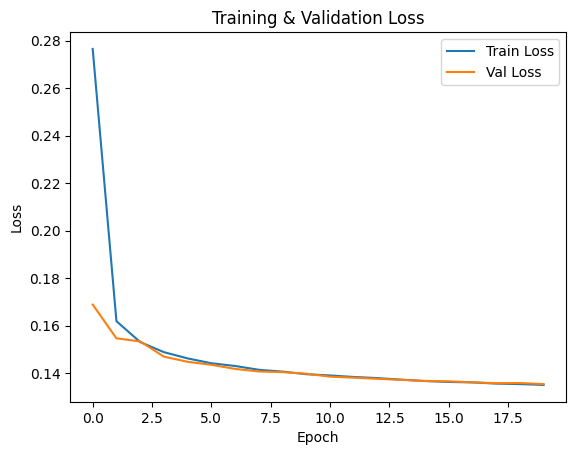

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


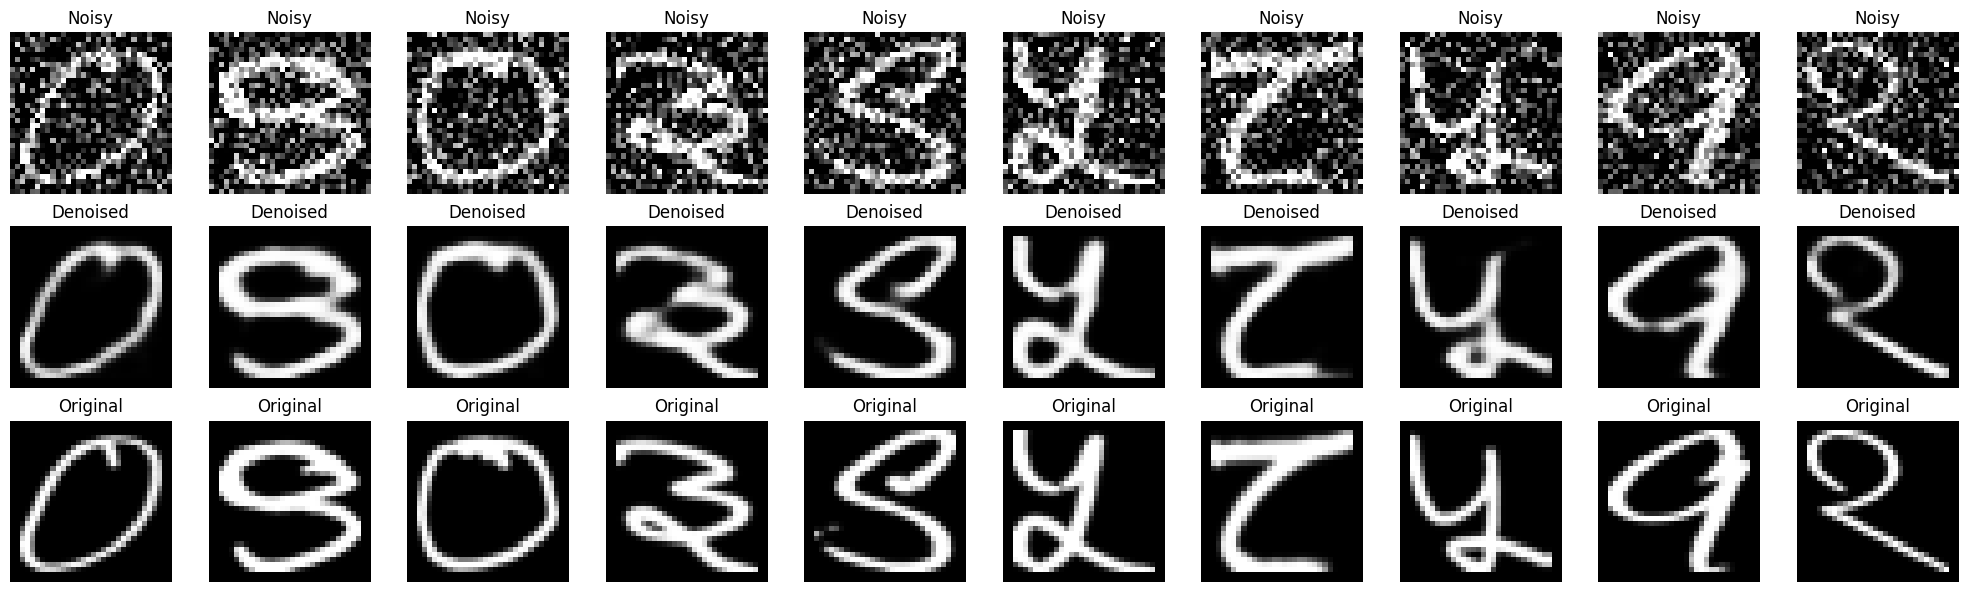

In [ ]:
denoised_images = autoencoder.predict(x_test_noisy)

def plot_images(noisy, denoised, clean, n=10):
    plt.figure(figsize=(20, 6))
    for i in range(n):
        # Noisy
        plt.subplot(3, n, i + 1)
        plt.imshow(noisy[i].reshape(32, 32), cmap='gray')
        plt.title("Noisy")
        plt.axis('off')

        # Denoised
        plt.subplot(3, n, i + 1 + n)
        plt.imshow(denoised[i].reshape(32, 32), cmap='gray')
        plt.title("Denoised")
        plt.axis('off')

        # Clean
        plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(clean[i].reshape(32, 32), cmap='gray')
        plt.title("Original")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_images(x_test_noisy, denoised_images, x_test)
